## TRAINING RETE NEURALE - classificazione captcha

In [2]:
# Import
import torch

In [3]:
# Setup device
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [4]:
# Define transform
import torchvision.transforms as T
# Define single transforms

# Note: transforms can also be regular functions
def normalize_(x):
    # Set values
    x[x > 0.5] = 1
    x[x <= 0.5] = -1
    # Return
    return x


normalize = normalize_


In [5]:
#resize 48x48
def resize_(img):   
    size = 48,48
    img = img.resize(size)
    return img

resize = resize_

In [6]:
transform = T.Compose([T.Grayscale(num_output_channels=1),
                       resize,
                       T.ToTensor(),
                       normalize])

In [7]:
# Class map
class_names = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',9:"J",10:"K",11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",24:"Y",25:"Z"};

In [8]:
import string
#string.ascii_uppercase

In [9]:
# Imports
from PIL import Image, ImageChops
from random import shuffle
from glob import glob
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
# Define root directory
root_dir = "./output/"

### Model definition

In [11]:
# Imports
import torch.nn as nn
import torch.nn.functional as F

# Convolutional layer
class ConvLayer(nn.Sequential):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.add_module('conv', nn.Conv2d(in_features, out_features, kernel_size=3))
        self.add_module('relu', nn.ReLU())
        self.add_module('pool', nn.MaxPool2d(kernel_size=2, stride=2))
        
# Convolutional layer
class ConvLayerBN(nn.Sequential):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.add_module('conv', nn.Conv2d(in_features, out_features, kernel_size=3))
        self.add_module('relu', nn.ReLU())
        self.add_module('bn', nn.BatchNorm2d(out_features))
        self.add_module('pool', nn.MaxPool2d(kernel_size=2, stride=2))

# Define model
class Model(nn.Module):
    def __init__(self):
        # Call parent
        super().__init__()
        # Convolutional layers
        self.convs = nn.Sequential(
            ConvLayerBN(1, 32),
            ConvLayerBN(32, 128)
        )
        # Computing encoding size
        self.convs.eval()
        test_x = torch.zeros(1, 1, 48,48) #DIMENSIONE IN PIXEL
        test_x = self.convs(test_x)
        encoding_size = test_x.numel()
        print(f"Encoding size: {encoding_size}")
        # FC layers
        self.fcs = nn.Sequential(
            nn.Linear(encoding_size, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, len(class_names))
        )
        
    def forward(self, x):
        # Compute output
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fcs(x)
        return x

### Datatets

In [ ]:
# Imports
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader
import PIL

batch_size=32

# Instantiate datasets
letter_train_dataset = ImageFolder(os.path.join(root_dir,  "train"), transform) #, loader=loader)
letter_val_dataset = ImageFolder(os.path.join(root_dir,  "val"), transform) #, loader=loader)
letter_test_dataset = ImageFolder(os.path.join(root_dir,  "test"), transform) #, loader=loader)

# Get number of classes (we'll need it in the model)
num_classes = len(letter_train_dataset.classes)

# Print dataset statistics
print(f"Num. classes: {num_classes}")
print(f"Num. train samples: {len(letter_train_dataset)}")
print(f"Num. valid. samples: {len(letter_val_dataset)}")
print(f"Num. test samples: {len(letter_test_dataset)}")


# Instantiate data loaders
loaders = {"train": DataLoader(dataset=letter_train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True),
           "val":   DataLoader(dataset=letter_val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
           "test":  DataLoader(dataset=letter_test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
          }

In [ ]:
letter_train_dataset[0][0].size()

### Train the Model

In [ ]:
# Imports
import torch.optim

# Create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
# Load checkpoint
start_epoch = 0
checkpoint = f"checkpoint-{start_epoch}.pth"
use_checkpoint = False

In [ ]:
# Check checkpoint
if use_checkpoint:
    state_dict = torch.load(checkpoint)
else:
    start_epoch = 0

# Create model for training
model = Model()
if use_checkpoint:
    model.load_state_dict(state_dict)
model.to(dev)

In [ ]:
# Test model output
model.eval()
test_input = letter_train_dataset[0][0].unsqueeze(0).to(dev)
print("Model output size:", model(test_input).size())

In [ ]:
# options
num_epochs = 30
save_every = 1

# Initialize training history

loss_history = {'train': [], 'val': [], 'test': []}
accuracy_history = {'train': [], 'val': [], 'test': []}
# Keep track of best validation accuracy
best_val_accuracy = 0
test_accuracy_at_best_val = 0
# Start training
for epoch in range(num_epochs):
    # Initialize accumulators for computing average loss/accuracy
    epoch_loss_sum = {'train': 0, 'val': 0, 'test': 0}
    epoch_loss_cnt = {'train': 0, 'val': 0, 'test': 0}
    epoch_accuracy_sum = {'train': 0, 'val': 0, 'test': 0}
    epoch_accuracy_cnt = {'train': 0, 'val': 0, 'test': 0}
    # Process each split
    for split in ["train", "val", "test"]:
        # Set network mode
        if split == "train":
            model.train()
            torch.set_grad_enabled(True)
        else:
            model.eval()
            torch.set_grad_enabled(False)
        # Process all data in split
        for (input,target) in loaders[split]:
            # Move to device
            input = input.to(dev)
            target = target.to(dev)
            # Forward
            output = model(input)
            loss = F.cross_entropy(output, target)
            # Update loss sum
            epoch_loss_sum[split] += loss.item()
            epoch_loss_cnt[split] += 1
            # Compute accuracy
            _,pred = output.max(1)
            correct = pred.eq(target).sum().item()
            accuracy = correct/input.size(0)
            # Update accuracy sum
            epoch_accuracy_sum[split] += accuracy
            epoch_accuracy_cnt[split] += 1
            # Backward and optimize
            if split == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    # Compute average epoch loss/accuracy
    avg_train_loss = epoch_loss_sum["train"]/epoch_loss_cnt["train"]
    avg_train_accuracy = epoch_accuracy_sum["train"]/epoch_accuracy_cnt["train"]
    avg_val_loss = epoch_loss_sum["val"]/epoch_loss_cnt["val"]
    avg_val_accuracy = epoch_accuracy_sum["val"]/epoch_accuracy_cnt["val"]
    avg_test_loss = epoch_loss_sum["test"]/epoch_loss_cnt["test"]
    avg_test_accuracy = epoch_accuracy_sum["test"]/epoch_accuracy_cnt["test"]
    print(f"Epoch: {epoch+1}, TL={avg_train_loss:.4f}, TA={avg_train_accuracy:.4f}, VL={avg_val_loss:.4f}, VA={avg_val_accuracy:.4f}, ŦL={avg_test_loss:.4f}, ŦA={avg_test_accuracy:.4f}")
    # Add to histories
    loss_history["train"].append(avg_train_loss)
    loss_history["val"].append(avg_val_loss)
    loss_history["test"].append(avg_test_loss)
    accuracy_history["train"].append(avg_train_accuracy)
    accuracy_history["val"].append(avg_val_accuracy)
    accuracy_history["test"].append(avg_test_accuracy)
    # Check best validation
    if avg_val_accuracy > best_val_accuracy:
        # Update best validation
        best_val_accuracy = avg_val_accuracy
        test_accuracy_at_best_val = avg_test_accuracy
   
    # Save checkpoint
    if epoch % save_every == 0:
        state_dict = model.state_dict()
        for k,v in state_dict.items():
            state_dict[k] = v.cpu() #conversione CUDA - CPU
        torch.save(state_dict, f"checkpoint-{epoch}.pth").

In [ ]:
# Print test accuracy at best validation accuracy
print(f"Final test accuracy {test_accuracy_at_best_val:.4f}")

In [ ]:
# Plot loss
x = torch.arange(1, len(loss_history["train"])+1).numpy()
plt.plot(x, loss_history["train"], label="train")
plt.plot(x, loss_history["val"], label="val")
plt.plot(x, loss_history["test"], label="test")
plt.legend()
plt.show()

In [ ]:
# Plot accuracy
x = torch.arange(1, len(loss_history["train"])+1).numpy()
plt.plot(x, accuracy_history["train"], label="train")
plt.plot(x, accuracy_history["val"], label="val")
plt.plot(x, accuracy_history["test"], label="test")
plt.legend()
plt.show()

In [ ]:
#Save the model
# Define root directory
save_path = f"./modello{num_epochs}.pt"
modello_salvato = model.state_dict()
torch.save(modello_salvato, save_path)

### Test the Model
Testing del modello trainato. Prima si generano dei captcha casuali.

In [16]:
model = Model()
model.load_state_dict(torch.load("./modello30.pt",map_location=dev))
model.eval()

model.cuda()

Encoding size: 12800


Model(
  (convs): Sequential(
    (0): ConvLayerBN(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (relu): ReLU()
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvLayerBN(
      (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
      (relu): ReLU()
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fcs): Sequential(
    (0): Linear(in_features=12800, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Linear(in_features=2048, out_features=26, bias=True)
  )
)

In [13]:
import os, random
import string
def getfirstUppercase(s):
    return ([char for char in s if char.isupper()])[0]

In [14]:
def sporca(path):
    dirs = os.listdir( path )
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            im = noisy(im,width=1000,height=200)
            im.save(f"{f}.png")

def noisy(img,width,height):
    draw = ImageDraw.Draw(img)
    for x in range(0,15):
        draw.point((random.randint(0,width),random.randint(0,height)),0)
        draw.line([(random.randint(0,width),random.randint(0,height)), (random.randint(0,width),random.randint(0,height))],width=3)

    return img

In [ ]:
path = "./matrici/originale/output/"
dirs = os.listdir( path )
if not os.path.exists("./CaptchaTest/"):
    os.makedirs("./CaptchaTest/")

total_width = 1000
max_height = 200
for v in range (0,5):
    new_im = Image.new("1", (total_width, max_height))
    filename = ""
    x_offset = 0
    list_images = []
    for i in range (0,5): #5 elementi
        curr_rand=random.randint(0,len(dirs)-1)
        list_images.append(path+dirs[curr_rand])
        valore = dirs[curr_rand]
        filename+=getfirstUppercase(valore)

    for im in list_images:
        image_cur = Image.open(im)
        new_im.paste(image_cur, (x_offset,0))
        x_offset += image_cur.size[0]

    new_im.save(f'./CaptchaTest/{filename}{v}.png') # es stringa AEDTG45.png

In [ ]:
#############################################

In [19]:
img.size

(2000, 200)

Predicted: R  with accuracy of: 55.12
Predicted: Y  with accuracy of: 54.73
Predicted: T  with accuracy of: 98.88
Predicted: H  with accuracy of: 92.09
Predicted: N  with accuracy of: 88.92
Predicted: G  with accuracy of: 97.52
Predicted: G  with accuracy of: 99.26
Predicted: D  with accuracy of: 99.89
Predicted: N  with accuracy of: 92.13
Predicted: F  with accuracy of: 70.52


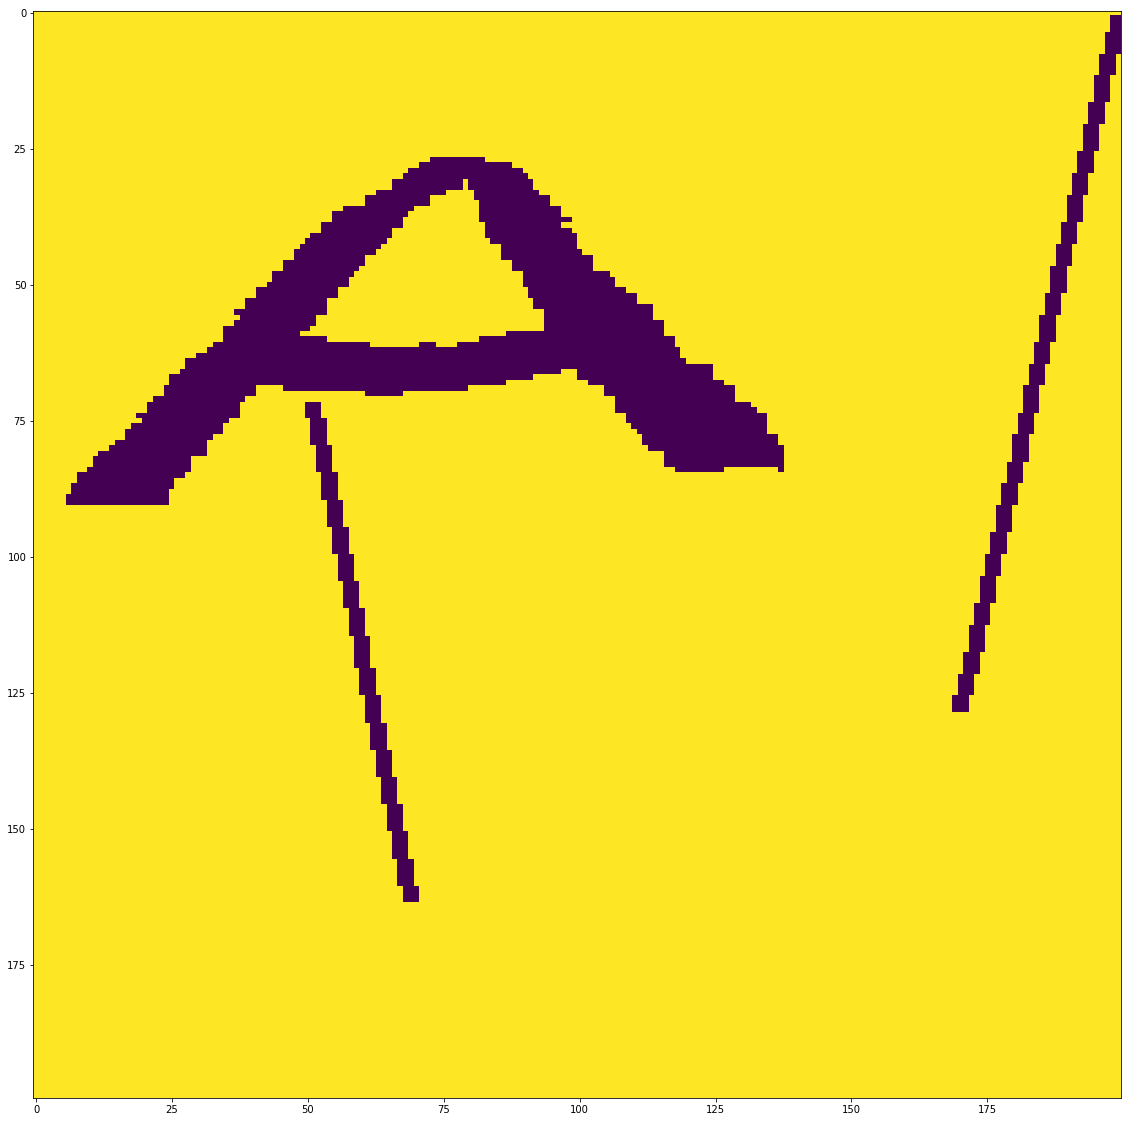

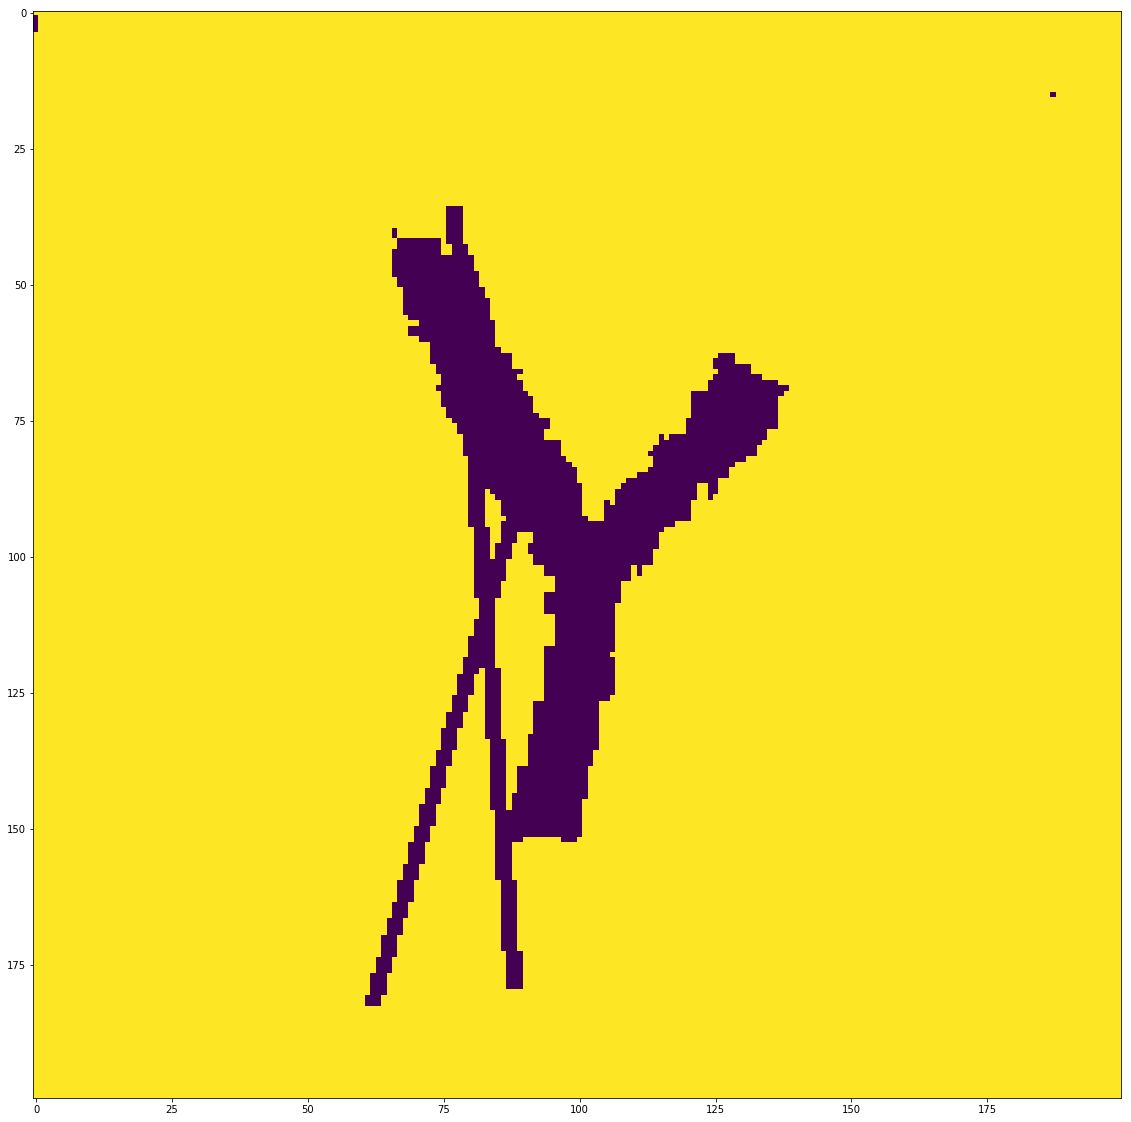

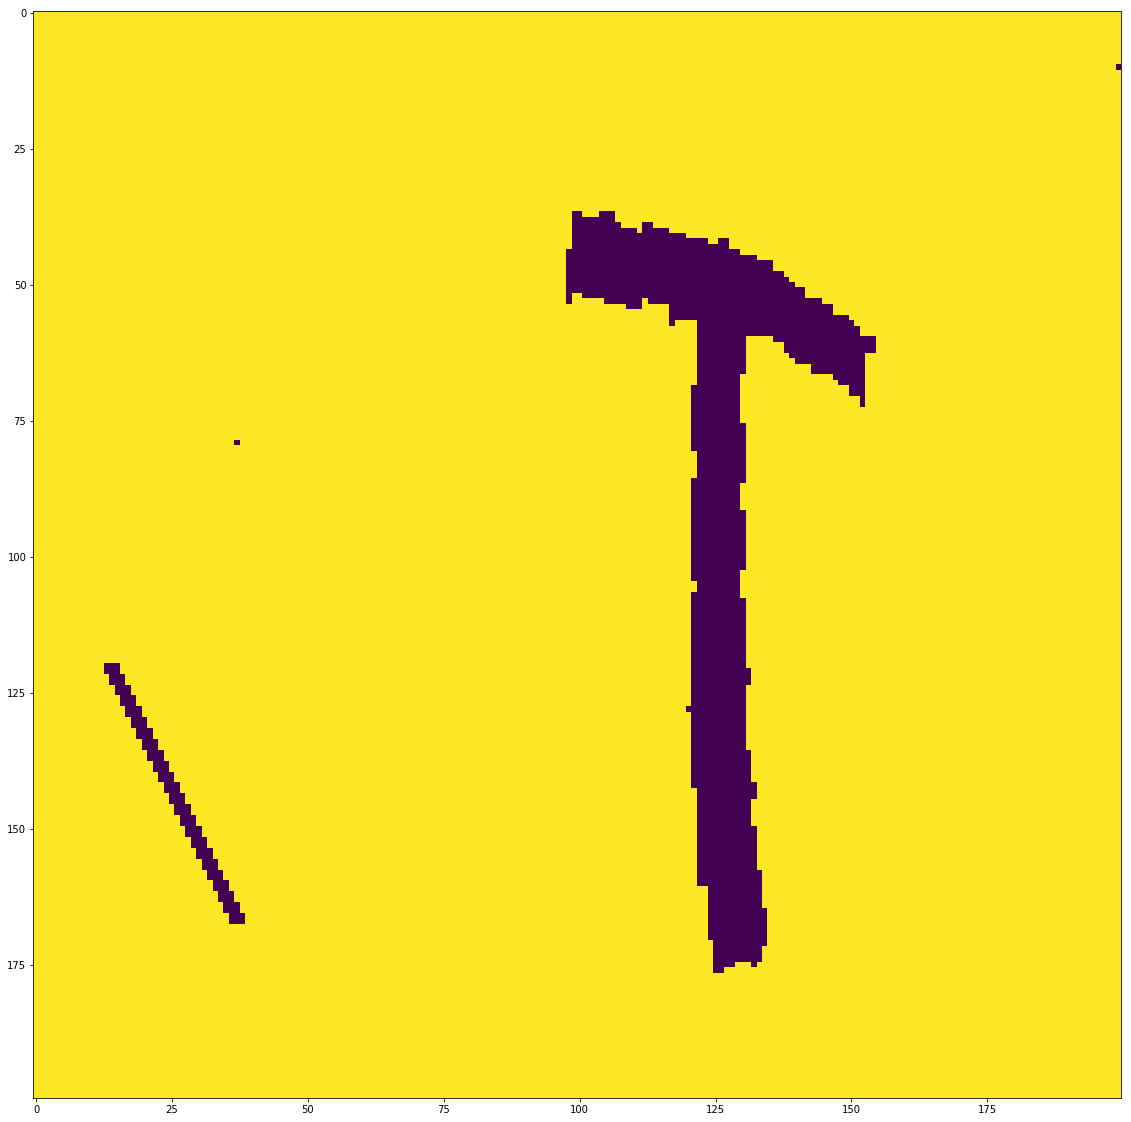

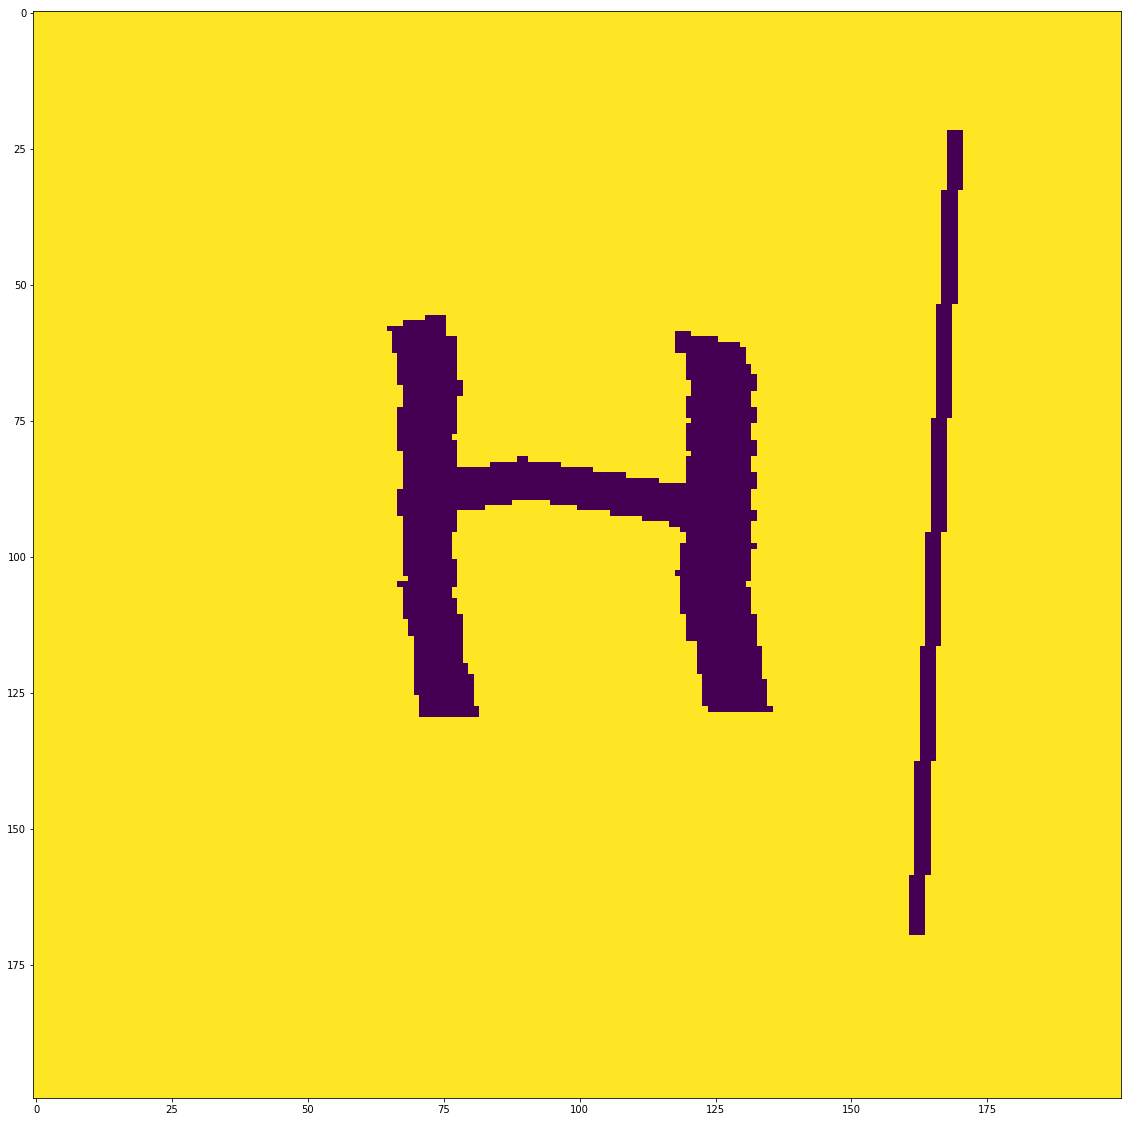

Error in callback <function flush_figures at 0x000000000BADA1E0> (for post_execute):


KeyboardInterrupt: 

In [24]:
# Define root directory
prova_dir = "./CaptchaTest/"

img = Image.open(os.path.join(prova_dir,"AYTHNGGDNF498.png"))

width, _ = img.size

label = ""

num_lett = int(width/200)

for i in range(0,num_lett):
    plt.figure(figsize=(2, 2)) #deve stare dentro per plottare le tre immmagini
    img = Image.open(os.path.join(prova_dir,"AYTHNGGDNF498.png"))
    img = img.convert('1')
    #crop ogni 200px 5 volte
    #0,0 200,200 - 200,0 400,200 - 400,0 600, 200
    current_box = img.crop((200*i,0,200*(i+1),200))

    input = transform(current_box)
    plt.imshow(current_box)
    # Predict class
    model.eval()
    with torch.no_grad():
        output = model(input.unsqueeze(0).to(dev))
    accuracy = output.softmax(1).max(1)
    accuracy = accuracy[0].item()*100
    _,pred = output.max(1)
    pred = pred.item()
    print(f"Predicted: {class_names[pred]}  with accuracy of: {'%.2f'%(accuracy)}")
    #print("secondo", f"{'%.2f'%(secondo)}")
    #plt.show(input)





In [ ]:
## Fill with borders
from PIL import ImageOps

# Define root directory
prova_dir = "F:/Programmazione/UO-Captcha-breaker/python-utils-scripts/test-folder/"

img = Image.open(prova_dir+"preview7.png")
plt.imshow(img)

img_with_border = ImageOps.expand(img,border=49,fill='black')
plt.imshow(img_with_border)


Esempio con test data

In [ ]:
#import random
# Define root directory
prova_dir = "F:/Programmazione/UO-Captcha-breaker/"


#transform = T.Compose([T.Grayscale(num_output_channels=1),
                       #T.ToTensor(),
                       #normalize])


#input, label = Image.open(prova_dir+"TEST42rgb.png")

# Get random sample from test set
#idx = random.randint(0, len(dog_test_dataset)-1)
input, label = dog_test_dataset[0]

# Normalize and show image
#input_show = (input - input.min())/(input.max() - input.min())
#plt.imshow(input_show.permute(1,2,0).numpy())
#plt.imshow(input_show)
#plt.axis('off')

# Predict class
model.eval()
with torch.no_grad():
    output = model(input.unsqueeze(0).to(dev))
_,pred = output.max(1)
pred = pred.item()
print(f"Predicted: {pred} (correct: {label})")

# Fine-tuning a model for dog detection

In fine-tuning, we will include layers from a pre-trained model into our own network, then train the whole model.

In [ ]:
# Load AlexNet model
alexnet = models.alexnet(pretrained=True)
alexnet = alexnet.to(dev)
print(alexnet)

Let's check the `features` property.

In [ ]:
# Test input
alexnet.eval()
test_x = torch.zeros(1, 3, 224, 224).to(dev)
# Forward whole model
print(alexnet(test_x).size())
# Forward features only
print(alexnet.features(test_x).size())

In [ ]:
# Define fine-tuned model
class FineTunedAlexNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Load AlexNet model
        alexnet = models.alexnet(pretrained=True)
        # Select feature extraction part
        self.features = alexnet.features
        self.fc1 = nn.Linear(256*6*6, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.output = nn.Linear(2048, 133)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.output(x),1)
        return x

In [ ]:
# Create model
model = FineTunedAlexNet()
model = model.to(dev);

In [ ]:
# Test model output
model.eval()
test_input = dog_train_dataset[0][0].unsqueeze(0).to(dev)
print("Model output size:", model(test_input).size())

### Train the Model

In [ ]:
# Imports
import torch.optim

# Create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
# Initialize training history
loss_history = {'train': [], 'val': [], 'test': []}
accuracy_history = {'train': [], 'val': [], 'test': []}
# Keep track of best validation accuracy
best_val_accuracy = 0
test_accuracy_at_best_val = 0
# Start training
for epoch in range(100):
    # Initialize accumulators for computing average loss/accuracy
    epoch_loss_sum = {'train': 0, 'val': 0, 'test': 0}
    epoch_loss_cnt = {'train': 0, 'val': 0, 'test': 0}
    epoch_accuracy_sum = {'train': 0, 'val': 0, 'test': 0}
    epoch_accuracy_cnt = {'train': 0, 'val': 0, 'test': 0}
    # Process each split
    for split in ["train", "val", "test"]:
        # Set network mode
        if split == "train":
            model.train()
            torch.set_grad_enabled(True)
        else:
            model.eval()
            torch.set_grad_enabled(False)
        # Process all data in split
        for (input,target) in loaders[split]:
            # Move to device
            input = input.to(dev)
            target = target.to(dev)
            # Forward
            output = model(input)
            loss = F.cross_entropy(output, target)
            # Update loss sum
            epoch_loss_sum[split] += loss.item()
            epoch_loss_cnt[split] += 1
            # Compute accuracy
            _,pred = output.max(1)
            correct = pred.eq(target).sum().item()
            accuracy = correct/input.size(0)
            # Update accuracy sum
            epoch_accuracy_sum[split] += accuracy
            epoch_accuracy_cnt[split] += 1
            # Backward and optimize
            if split == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    # Compute average epoch loss/accuracy
    avg_train_loss = epoch_loss_sum["train"]/epoch_loss_cnt["train"]
    avg_train_accuracy = epoch_accuracy_sum["train"]/epoch_accuracy_cnt["train"]
    avg_val_loss = epoch_loss_sum["val"]/epoch_loss_cnt["val"]
    avg_val_accuracy = epoch_accuracy_sum["val"]/epoch_accuracy_cnt["val"]
    avg_test_loss = epoch_loss_sum["test"]/epoch_loss_cnt["test"]
    avg_test_accuracy = epoch_accuracy_sum["test"]/epoch_accuracy_cnt["test"]
    print(f"Epoch: {epoch+1}, TL={avg_train_loss:.4f}, TA={avg_train_accuracy:.4f}, VL={avg_val_loss:.4f}, VA={avg_val_accuracy:.4f}, ŦL={avg_test_loss:.4f}, ŦA={avg_test_accuracy:.4f}")
    # Add to histories
    loss_history["train"].append(avg_train_loss)
    loss_history["val"].append(avg_val_loss)
    loss_history["test"].append(avg_test_loss)
    accuracy_history["train"].append(avg_train_accuracy)
    accuracy_history["val"].append(avg_val_accuracy)
    accuracy_history["test"].append(avg_test_accuracy)
    # Check best validation
    if avg_val_accuracy > best_val_accuracy:
        # Update best validation
        best_val_accuracy = avg_val_accuracy
        test_accuracy_at_best_val = avg_test_accuracy

In [ ]:
# Print test accuracy at best validation accuracy
print(f"Final test accuracy {test_accuracy_at_best_val:.4f}")

In [ ]:
# Plot loss
x = torch.arange(1, len(loss_history["train"])+1).numpy()
plt.plot(x, loss_history["train"], label="train")
plt.plot(x, loss_history["val"], label="val")
plt.plot(x, loss_history["test"], label="test")
plt.legend()
plt.show()

In [ ]:
# Plot accuracy
x = torch.arange(1, len(loss_history["train"])+1).numpy()
plt.plot(x, accuracy_history["train"], label="train")
plt.plot(x, accuracy_history["val"], label="val")
plt.plot(x, accuracy_history["test"], label="test")
plt.legend()
plt.show()

### Test the model

In [ ]:
import random

# Get random sample from test set
idx = random.randint(0, len(dog_test_dataset)-1)
input, label = dog_test_dataset[idx]
# Normalize and show image
input_show = (input - input.min())/(input.max() - input.min())
plt.imshow(input_show.permute(1,2,0).numpy())
plt.axis('off')
# Predict class
model.eval()
with torch.no_grad():
    output = model(input.unsqueeze(0).to(dev))
_,pred = output.max(1)
pred = pred.item()
print(f"Predicted: {pred} (correct: {label})")

# Using a pre-trained model as a feature extractor

Fully-connected layer of models pre-trained on ImageNet can also work as generic image descriptors, because they compactly represent image content.

Feature extraction means that we pass an image to a CNN model, but only get the output of a fully-connected layer, and use that output instead of the fully image. Then, we train a simpler classifier (SVM or MLP) on the extracted features.

Feature extraction in PyTorch may be tricky sometimes, depending on how the model is defined. We will see two methods to extract features.

### 1) Modifying layers

Let's see the Alexnet model.

In [ ]:
# Load AlexNet model
alexnet = models.alexnet(pretrained=True)
alexnet = alexnet.to(dev)
alexnet.eval()
print(alexnet)

In [ ]:
# Print test output
alexnet(torch.zeros(1, 3, 224, 224).to(dev)).size()

For example, let's suppose we want the output of the last FC layer (before classification). In practice, we want the output of layer `5` inside the `classifier` block. The problem is that `classifier` is a `Sequential`, so we cannot directly get the output of an intermediate layer.

One solution is to modify the `classifier` block.

In [ ]:
# Print classifier block
alexnet.classifier

In [ ]:
# Sequential children
alexnet.classifier.children()

In [ ]:
# Convert generator to list
list(alexnet.classifier.children())

In [ ]:
# Remove the final linear layer
new_classifier_modules = list(alexnet.classifier.children())
new_classifier_modules = new_classifier_modules[:-1]

In [ ]:
# Print the new list of modules
new_classifier_modules

In [ ]:
# Create a new Sequential container
new_classifier = nn.Sequential(*new_classifier_modules)

In [ ]:
# Replace the classifier
alexnet.classifier = new_classifier

In [ ]:
# Print test output
test_out = alexnet(torch.zeros(1, 3, 224, 224).to(dev))
print(test_out.size())

In [ ]:
# Keep output for later
features_1 = test_out.clone()

In this way, our `alexnet` model now returns directly the output of a fully-connected layer. However, this was easy because `classifier` is the last block of the model, so there's nothing after it that depends on it.

In other cases, it may not be so easy. For example, consider the [`inception_v3`](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py) model.

In that case, layers are defined as individual class properties, and the `forward()` method calls them in turn. If we want to extract features, we should modify the `forward()` method. It can be done, but it's not trivial, and there's a cleaner way: **hooks**.

### 2) Forward hooks

Hooks are callback functions associated to `nn.Module`s, that are invoked during forward (_forward hook_) or during backpropagation (_backward hook_).

When you _register_ a hook, you ask the model to call your function whenever a layer processes input data. Your function will receive the input and output of the module.

Another way to implement feature extraction is to set up a forward hook on our target layer, get the layer's output, and save it in a variable.

In [ ]:
# Load AlexNet model
alexnet = models.alexnet(pretrained=True)
alexnet = alexnet.to(dev)
alexnet.eval()
print(alexnet)

In [ ]:
# Feature extraction class
class FeatureExtractor:
    
    # Constructor: receives model and target layer
    def __init__(self, model, layer):
        # Save model
        self.model = model
        self.model.eval()
        # Internal variable to store target features
        self.features = None
        # Define hook
        def forward_hook(module, input, output):
            # Copy features
            self.features = output.clone()
        # Register hook
        layer.register_forward_hook(forward_hook)
        
    # Function interface
    def __call__(self, input):
        with torch.no_grad():
            # Forward through model
            self.model(input)
        # Return features
        return self.features

How to get reference to target layer?

Just traverse the model.

In [ ]:
alexnet

In [ ]:
alexnet.classifier

In [ ]:
alexnet.classifier[5]

In [ ]:
# Create extractor
feat_extr = FeatureExtractor(alexnet, alexnet.classifier[5])

In [ ]:
# Print test output
test_out = feat_extr(torch.zeros(1, 3, 224, 224).to(dev))
print(test_out.size())

In [ ]:
# Compare features
features_2 = test_out
print((features_1 - features_2).abs().max())

Let's use our feature extraction to process all data

In [ ]:
# Get number of features
num_features = feat_extr(dog_train_dataset[0][0].unsqueeze(0).to(dev)).numel()
print(num_features)

In [ ]:
# Create data matrices (num_samples x num_features)
datasets = {"train": dog_train_dataset, "val": dog_val_dataset, "test": dog_test_dataset}
features = {"train": torch.Tensor(len(dog_train_dataset), num_features),
            "val":   torch.Tensor(len(dog_val_dataset), num_features),
            "test":  torch.Tensor(len(dog_test_dataset), num_features)
           }
labels = {"train": torch.LongTensor(len(dog_train_dataset)),
          "val":   torch.LongTensor(len(dog_val_dataset)),
          "test":  torch.LongTensor(len(dog_test_dataset))
         }
# Fill the features for each split
for split in ["train", "val", "test"]:
    print(f"Processing {split} split")
    # Process each sample in the split
    for i in range(len(datasets[split])):
        # Get sample
        sample,label = datasets[split][i]
        # Compute features
        sample = sample.unsqueeze(0).to(dev)
        feats = feat_extr(sample)
        # Copy features
        features[split][i] = feats
        labels[split][i] = label

We now have our data formatted as in our initial examples with linear regression and classification. However, we can still use the standard `DataLoader` interface, by wrapping our matrices as `TensorDataset` objects. In a `TensorDataset`, you can pass any kind of tensors as source data, and sample selection is performed by indexing the first dimension (in our case, rows). 

In [ ]:
# Import
from torch.utils.data import TensorDataset
# Prepare tensor datasets
tensor_datasets = {
    split: TensorDataset(features[split], labels[split]) for split in features
}

In [ ]:
# Instantiate data loaders
loaders = {"train": DataLoader(dataset=tensor_datasets["train"], batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True),
           "val":   DataLoader(dataset=tensor_datasets["val"],   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
           "test":  DataLoader(dataset=tensor_datasets["test"],  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
          }

Let's now train a linear classifier on the extracted features.

In [ ]:
# Create model
model = nn.Linear(num_features, num_classes)
model = model.to(dev);

In [ ]:
# Test model output
model.eval()
test_input = tensor_datasets["train"][0][0].unsqueeze(0).to(dev)
print("Model output size:", model(test_input).size())

### Train the model

In [ ]:
# Imports
import torch.optim

# Create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
# Initialize training history
loss_history = {'train': [], 'val': [], 'test': []}
accuracy_history = {'train': [], 'val': [], 'test': []}
# Keep track of best validation accuracy
best_val_accuracy = 0
test_accuracy_at_best_val = 0
# Start training
for epoch in range(100):
    # Initialize accumulators for computing average loss/accuracy
    epoch_loss_sum = {'train': 0, 'val': 0, 'test': 0}
    epoch_loss_cnt = {'train': 0, 'val': 0, 'test': 0}
    epoch_accuracy_sum = {'train': 0, 'val': 0, 'test': 0}
    epoch_accuracy_cnt = {'train': 0, 'val': 0, 'test': 0}
    # Process each split
    for split in ["train", "val", "test"]:
        # Set network mode
        if split == "train":
            model.train()
            torch.set_grad_enabled(True)
        else:
            model.eval()
            torch.set_grad_enabled(False)
        # Process all data in split
        for (input,target) in loaders[split]:
            # Move to device
            input = input.to(dev)
            target = target.to(dev)
            # Forward
            output = model(input)
            loss = F.cross_entropy(output, target)
            # Update loss sum
            epoch_loss_sum[split] += loss.item()
            epoch_loss_cnt[split] += 1
            # Compute accuracy
            _,pred = output.max(1)
            correct = pred.eq(target).sum().item()
            accuracy = correct/input.size(0)
            # Update accuracy sum
            epoch_accuracy_sum[split] += accuracy
            epoch_accuracy_cnt[split] += 1
            # Backward and optimize
            if split == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    # Compute average epoch loss/accuracy
    avg_train_loss = epoch_loss_sum["train"]/epoch_loss_cnt["train"]
    avg_train_accuracy = epoch_accuracy_sum["train"]/epoch_accuracy_cnt["train"]
    avg_val_loss = epoch_loss_sum["val"]/epoch_loss_cnt["val"]
    avg_val_accuracy = epoch_accuracy_sum["val"]/epoch_accuracy_cnt["val"]
    avg_test_loss = epoch_loss_sum["test"]/epoch_loss_cnt["test"]
    avg_test_accuracy = epoch_accuracy_sum["test"]/epoch_accuracy_cnt["test"]
    print(f"Epoch: {epoch+1}, TL={avg_train_loss:.4f}, TA={avg_train_accuracy:.4f}, VL={avg_val_loss:.4f}, VA={avg_val_accuracy:.4f}, ŦL={avg_test_loss:.4f}, ŦA={avg_test_accuracy:.4f}")
    # Add to histories
    loss_history["train"].append(avg_train_loss)
    loss_history["val"].append(avg_val_loss)
    loss_history["test"].append(avg_test_loss)
    accuracy_history["train"].append(avg_train_accuracy)
    accuracy_history["val"].append(avg_val_accuracy)
    accuracy_history["test"].append(avg_test_accuracy)
    # Check best validation
    if avg_val_accuracy > best_val_accuracy:
        # Update best validation
        best_val_accuracy = avg_val_accuracy
        test_accuracy_at_best_val = avg_test_accuracy

In [ ]:
# Print test accuracy at best validation accuracy
print(f"Final test accuracy {test_accuracy_at_best_val:.4f}")

In [ ]:
# Plot loss
x = torch.arange(1, len(loss_history["train"])+1).numpy()
plt.plot(x, loss_history["train"], label="train")
plt.plot(x, loss_history["val"], label="val")
plt.plot(x, loss_history["test"], label="test")
plt.legend()
plt.show()

In [ ]:
# Plot accuracy
x = torch.arange(1, len(loss_history["train"])+1).numpy()
plt.plot(x, accuracy_history["train"], label="train")
plt.plot(x, accuracy_history["val"], label="val")
plt.plot(x, accuracy_history["test"], label="test")
plt.legend()
plt.show()

In [ ]:
import random

# Get random sample from test set
idx = random.randint(0, len(dog_test_dataset)-1)
input, label = dog_test_dataset[idx]
# Normalize and show image
input_show = (input - input.min())/(input.max() - input.min())
plt.imshow(input_show.permute(1,2,0).numpy())
plt.axis('off')
# Extract features
input = feat_extr(input.unsqueeze(0).to(dev))
# Predict class
model.eval()
with torch.no_grad():
    output = model(input)
_,pred = output.max(1)
pred = pred.item()
print(f"Predicted: {pred} (correct: {label})")